In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten

from tensorflow.python.keras.optimizers import Adam

from cifar10 import img_size, num_channels, num_classes


This was developed using Python 3.6 (Anaconda) and TensorFlow version:

In [2]:
tf.__version__

'1.14.0'

## Load Data

In [3]:
import cifar10
import cifar10_helper_functions

cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [4]:
class_names = cifar10.load_class_names()
class_names

Loading data: ./data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
# labels_train => one-hot(cls_train)
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: ./data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: ./data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: ./data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: ./data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: ./data/CIFAR-10/cifar-10-batches-py/data_batch_5


In [6]:
images_test, cls_test, labels_test = cifar10.load_test_data()


Loading data: ./data/CIFAR-10/cifar-10-batches-py/test_batch


In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


The images are 32 x 32 pixels, but we will crop the images to 24 x 24 pixels.

In [8]:
img_size_cropped = 24
img_size_flat = img_size_cropped * img_size_cropped * 3
img_shape_full = (-1, img_size_cropped, img_size_cropped, num_channels)

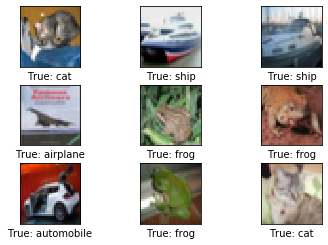

In [9]:
# Get the first images from the test-set.
images = images_test[0:9]

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
cifar10_helper_functions.plot_images(images=images, cls_true=cls_true, class_names=class_names, smooth=False)


In [10]:
def pre_process_image(image, training, img_size_cropped=24):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.

    if training:
        # For training, add the following to the TensorFlow graph.

        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)

        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. It is unclear from the
        # documentation of TensorFlow 0.10.0rc0 whether this is
        # intended. A simple solution is to limit the range.

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image


def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

In [11]:
images_train_distored = pre_process(images=images_train, training=True)
images_test_distored = pre_process(images=images_test, training=False)


## Model

In [12]:
model= Sequential()
# First convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=64, padding='same',
                 activation='relu', name='layer_conv1', input_shape=(24, 24, 3)))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(kernel_size=5, strides=1, filters=64, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(256, activation='relu', name='layer_fc1'))
model.add(Dense(128, activation='relu', name='layer_fc2'))

model.add(Dense(num_classes, activation='softmax'))


W0710 14:40:40.090207 11816 deprecation.py:506] From c:\users\jonat\pycharmprojects\deeplearning\venv\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
optimizer = Adam(lr=1e-4)


In [14]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv1 (Conv2D)         (None, 24, 24, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 12, 12, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
layer_fc1 (Dense)            (None, 256)               590080    
_________________________________________________________________
layer_fc2 (Dense)            (None, 128)               3

In [ ]:
model.fit(x=images_train_distored,
          y=labels_train,
          epochs=1,
          steps_per_epoch=10,
          batch_size=128)

result = model.evaluate(x=images_train_distored,
                        y=labels_test)

In [ ]:
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))
